In [1]:
%pylab inline
import math
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import collections
from itertools import product

Populating the interactive namespace from numpy and matplotlib


# 1-Ranking pairs
This block of code generates a list with every possible combination of 5-ranking tuples, with a total of 59049 elements. Each pair consists of (E, P) rankings.

In [2]:
temp = list(product(['N', 'R', 'HR'], repeat=5))
pairs = list([list(i), list(j)] for i in temp for j in temp)

# print(pairs[60:65])

# 2-Evaluation measures
## Binary evaluation measure
We chose to implement precision as it is an evaluation measure that doesn't need the total amount of relevant and highly relevant documents.

Precision is calculated as follows:

$precision=\dfrac{TP}{TP + FP}$

where *TP* and *FP* are the true positives and false positives, respectively. In our case *TP + FP = 5* and *TP = [R, HR]*

In [3]:
def precision(input_tuple, k=5):
    tp = 0.0
    for i in range(k):
        if input_tuple[i] != 'N':
            tp += 1.0
    return tp/k

# print(precision(pairs[65][1]))

## Multi-graded evaluation measures
For the second type of evaluation measures we decided to implement *DCG (Discounted Gumulative Gain)* and *RBP (Rank Biased Precision)*. Both metrics don't require the total amount of relevant and highly relevant documents, like precision.

*DCG* is defined as follows:

$DCG=\displaystyle\sum_{rank\ r=1}^{k}\dfrac{2^{rel_r}-1}{log_2(1+r)}$

*RBP* is defined as follows:

$RBP=\displaystyle\sum_{k=1}^{\infty}rel_k\theta^{k-1}(1-\theta)$

In [4]:
def DCG(input_tuple, k=5):
    dcg = 0
    for i in range(k):
        dcg += (pow(2, ['N', 'R', 'HR'].index(input_tuple[i]) + 1) - 1) / np.log2(i+2)
    return dcg

# print(DCG(pairs[65][1]))

In [5]:
def RBP(input_tuple, theta=0.8):
    rbp = 0
    for i in range(len(input_tuple)):
        rbp += (['N', 'R', 'HR'].index(input_tuple[i]) + 1) * pow(theta, i) * (1-theta)
    return rbp

# print(RBP(pairs[65][1]))

# 3-Deltas calculation
Deltas are calculated as follows:

$\Delta_{measure}=measure_E - measure_P$

The output is given as a tuple $((E, P), delta_1, delta_2, delta_3)$, and if E doesn't outperform P, the corresponding delta is set to *None*

In [6]:
def calculate_deltas(pairs):
    measures = []
    
    for pair in pairs:
        precision_diff = precision(pair[0]) - precision(pair[1])
        precision_diff = precision_diff if precision_diff > 0 else None
        
        dgc_diff = DCG(pair[0]) - DCG(pair[1])
        dgc_diff = dgc_diff if dgc_diff > 0 else None
        
        rbp_diff = RBP(pair[0]) - RBP(pair[1])
        rbp_diff = rbp_diff if rbp_diff > 0 else None
        
        measures.append((pair, precision_diff, dgc_diff, rbp_diff))
    return measures

measures = calculate_deltas(pairs)

# 4-Interleavings implementation
## Balanced interleaving
The output, when no clicks are given, is a list of pairs, each one containing the document chosen and the original algorithm that ranked it, in the form 

$[(rank_1, algorithm), (rank_2, algorithm), ..., (rank_n, algorithm)]$

When clicks are given, the algorithm outputs the winning algorithm.

In [7]:
def interleave_rankings_balanced(rankings):
    interleaved_ranking = []
    
    length_ranking_E = len(rankings[0])
    length_ranking_P = len(rankings[1])
    index_e = 0
    index_p = 0
    
    e_is_first = False
    if(random.uniform(0, 1) > 0.5):
        e_is_first = True
    
    
    while(index_e < length_ranking_E or index_p < length_ranking_P):
        if(index_e == length_ranking_E and index_p < length_ranking_P):
            interleaved_ranking.append((rankings[1][index_p], "P"))
            index_p += 1
        elif(index_p == length_ranking_P and index_e < length_ranking_E):
            interleaved_ranking.append((rankings[0][index_e], "E"))
            index_e += 1
        elif(index_e == index_p):
            if(e_is_first):
                interleaved_ranking.append((rankings[0][index_e], "E"))
                index_e += 1
            else:
                interleaved_ranking.append((rankings[1][index_p], "P"))
                index_p += 1
        else:
            if(index_e < index_p):
                interleaved_ranking.append((rankings[0][index_e], "E"))
                index_e += 1
            else:
                interleaved_ranking.append((rankings[1][index_p], "P"))
                index_p += 1
                       
    return interleaved_ranking
    


def balanced_interleaving(rankings, clicks):
    if(clicks is None):
         return interleave_rankings_balanced(rankings)
    else:
        if(len(clicks) == 0):
            return 'P'
        counts = []
        for rank in clicks:
            counts.append(rankings[rank-1][1])
        
        #print(counts)
        if(counts.count('E') == counts.count('P')):
            return 'P'
        data = collections.Counter(counts)
        return data.most_common(1)[0][0]

# interleaving = balanced_interleaving(pairs[65], None)
# print('Balanced interleaving', interleaving)
# print('Winning algorithm', balanced_interleaving(interleaving, [1,3,4]))

## Probabilistic interleaving
This interleaving requires the use of a softmax function, that gives higher probability to documents with higher rank, normalizing it with the probabilities of all the other documents.

The softmax function is defined as follows:

$P_{s_x}(d)=\dfrac{\dfrac{1}{r_x(d)^\tau}}{\displaystyle\sum_{d'\in D}\dfrac{1}{r_x(d')^\tau}}$

The output is the same as the interleaving above.

In [8]:
def softmax(rank, input_tuple, theta):
    denominator = 0
    for i in range(len(input_tuple)):
        denominator += 1/pow(i+1, theta)
    return (1/pow(rank, theta))/denominator

# print(softmax(1, pairs[65][1], 3))

In [9]:
def interleave_rankings_probabilistic(rankings, theta=3):
    interleaved_ranking = []
    
    temp_rankings = [list(rankings[0]), list(rankings[1])]
    
    while(len(temp_rankings[0]) != 0 or len(temp_rankings[1]) != 0):
        if(len(temp_rankings[0]) != 0 and len(temp_rankings[1]) != 0):
            e_is_first = 0
            if(random.uniform(0, 1) > 0.5):
                e_is_first = 1
        elif len(temp_rankings[0]) == 0:
            e_is_first = 1
        elif len(temp_rankings[1]) == 0:
            e_is_first = 0
        
        probabilities = 0
        rnd = random.uniform(0, 1)
        i = 0
        while rnd >= probabilities: # Check numerical problems (rnd=1)
            probabilities += softmax(i+1, temp_rankings[e_is_first], theta)
            i+=1
            
        
        interleaved_ranking.append((temp_rankings[e_is_first][i-1], ['E', 'P'][e_is_first]))
        del temp_rankings[e_is_first][i-1]
        
    #print(interleaved_ranking)
    return interleaved_ranking
        

def probabilistic_interleaving(rankings, clicks):
    if(clicks is None):
         return interleave_rankings_probabilistic(rankings)
    else:
        if(len(clicks) == 0):
            return 'P'
        counts = []
        for rank in clicks:
            counts.append(rankings[rank-1][1])
        
        if(counts.count('E') == counts.count('P')):
            return 'P'
        data = collections.Counter(counts)
        return data.most_common(1)[0][0]
    
# interleaving = probabilistic_interleaving(pairs[65], None)
# print('Probabilistic interleaving', interleaving)
# print('Winning algorithm', probabilistic_interleaving(interleaving, [1,3,4]))

# 5-Click models
## Random click model
This model simply simulates a click on each document with probability $\rho$

In [10]:
def random_click_model(rankings, rho):
    clicks = []
    for i in range(len(rankings)):
        if random.uniform(0, 1) < rho:
            clicks.append(i+1)
    return clicks
    
# random_click_model(pairs[65][1], 0.6)

## Position based model
This model clicks on a document if, after examination ($\gamma$), its results attractive enough ($\alpha$). The values for the attractiveness parameter will not be learned, and instead we chose some empirical values based on the relevance factor.

In [23]:
def estimate_alpha(relevance_factor):
    if(relevance_factor == 'N'):
        return 0.3
    if(relevance_factor == 'R'):
        return 0.8
    if(relevance_factor == 'HR'):
        return 0.95

def position_based_model(rankings, gammas):
    clicks = []
    for i in range(min(len(rankings), len(gammas))):
        rnd = random.uniform(0, 1)
        if rnd < gammas[i]:
            rnd = random.uniform(0, 1)
            if rnd < estimate_alpha(rankings[i][0]):
                clicks.append(i+1)
    return clicks

#print pairs[64][1]
# position_based_model(pairs[65][1], gammas=[0.96, 0.77, 0.5, 0.34, 0.12])

## Parameters estimation
In order to estimate the parameters of the above click models, we will use Maximum Likelihood Estimation and the Expectation Maximization algorithm.

The first code performs simple loading and parsing of the training file, removing the final character *\n* and separating the values at each *\t* character.

In [12]:
#cd D:\MsC AI\1st year\1st semester\3rd period\Information Retrieval\Assignments\1st Assignment

In [14]:
data = []
with open('YandexRelPredChallenge.txt') as f:
    for line in f:
        data.append(line.replace('\n', '').split('\t'))

The only parameter to estimate for the Random Click Model is $\rho$, calculated using Maximum Likelihood Estimation

$\rho_{MLE} = \dfrac{\#clicks}{\#shown\ documents}$

In [15]:
def estimate_RCM_parameters(data):
    shown_documents = 0.0
    clicks = 0.0
    for line in data:
        if line[2] == 'Q':
            shown_documents += len(line[5:])
        elif line[2] == 'C':
            clicks += 1
    return clicks/shown_documents

rho = estimate_RCM_parameters(data)
# print('rho', rho)

In order to estimate the parameters for the Position Based Model, we have to use an iterative algorithm, formally known as the EM algorithm. In our implementation, the algorithm performs a fixed number of steps in order to converge to the final parameters value. Also, the value for the alphas is fixed, since it wouldn't make sense for it to be calculated with the given data.

The output consists of the final values for the gammas and alphas, in the form $[\gamma_1, \ldots, \gamma_{10}], [\alpha_1, \ldots, \alpha_{10}]$

We assume that queries are made separately (that is, that there can't be concurrent queries occurring), so a click on a document can only be associated to the last query that has been sent.

In [20]:
def estimate_PBM_parameters(data):
    gammas = [0.5 for i in range(10)]
    gammas[0] = 1.0
    alphas = [0.2 for i in range(10)]
    
    for i in range(100): 
        sums = [0.0 for i in range(10)]
        queries = 0.0
        
        for j, entry in enumerate(data):
            if entry[2] == 'Q':
                queries += 1
                for k in range(len(gammas)):
                    click = 0
                    l=j+1
                    while l<len(data) and data[l][2] == 'C':
                        if data[l][3] == entry[5+k]:
                            click = 1
                            break
                        l += 1
                    
                    sums[k] += click + (1 - click) * ((1 - alphas[k]) * gammas[k]) / (1 - gammas[k] * alphas[k])
        
        
        for k in range(len(gammas)):
            gammas[k] = sums[k]/queries
    return gammas, alphas

gammas, alphas = estimate_PBM_parameters(data)
# print(gammas, alphas)

# 6-Interleaving simulation
This step goes through every combination of interleaving and click model N times, and outputs a list containing the proportion *p* of wins for the algorithm E compared to P. The order of the proportions is

*[RCM-balanced, PBM-balanced, RCM-probabilistic, PBM-probabilistic]*

For each pair it also returns the percentage of times E was better than P, for each algorithm combination above. 

In [21]:
def determine_winning_algorithm(pairs, rho, gammas):
    individual_results = [np.zeros(4) for i in range(len(pairs))]
    N = 50
    E_wins = [0.0 for i in range(4)] #RC-balanced, PBM-balanced, RC-probabilistic, PBM-probabilistic
    number_of_runs = 0.0
    final_results = [0.0 for i in range(4)]
    
    for i in range(N):
        for j, pair in enumerate(pairs):
            balanced_interleaved = balanced_interleaving(pair, None)
            probabilistic_interleaved = probabilistic_interleaving(pair, None)
            random_clicks_balanced = random_click_model(balanced_interleaved, rho)
            random_clicks_probabilistic = random_click_model(probabilistic_interleaved, rho)
            PBM_clicks_balanced = position_based_model(balanced_interleaved, gammas)
            PBM_clicks_probabilistic = position_based_model(probabilistic_interleaved, gammas)
#             if(j == 1):
#                 print balanced_interleaved
#                 print PBM_clicks_balanced
#                 print PBM_clicks_probabilistic
#                 print "-------"
            
            number_of_runs += 1
            
            if(balanced_interleaving(balanced_interleaved, random_clicks_balanced) == 'E'):
                E_wins[0] += 1.0
                individual_results[j][0] += 1.0
            if(balanced_interleaving(balanced_interleaved, PBM_clicks_balanced) == 'E'):
                E_wins[1] += 1.0
                individual_results[j][1] += 1.0
            if(probabilistic_interleaving(probabilistic_interleaved, random_clicks_probabilistic) == 'E'):
                E_wins[2] += 1.0
                individual_results[j][2] += 1.0
            if(probabilistic_interleaving(probabilistic_interleaved, PBM_clicks_probabilistic) == 'E'):
                E_wins[3] += 1.0
                individual_results[j][3] += 1.0
                
    for i in range(4):
        final_results[i] = E_wins[i]/number_of_runs
    for i in range(len(pairs)):
        individual_results[i] /= (1.0*N)
        
#     print final_results
#     print individual_results[:10]
    return final_results, individual_results

final_results, individual_results = determine_winning_algorithm(pairs, rho, gammas)

# 7-Results and analysis
The following plots show the various levels of correlation between each combination of offline and online measures, for each pair of rankings ((E, P) pairs) where the respective $\Delta_{measure}$ is bigger than 0. For each combination of interleaving and click model, an analysis is made. On the x axis we have the values for the online measure, while on the y axis we have the value of the offline measure. Higher values on the x axis indicates that the percentage of E wins over P is higher. Above each plot the Pearson and Spearman correlation is indicated: a Pearson correlation close to 0 indicates almost nonexistent linear correlation between the data, while higher values indicate an increase in correlation. Similarly, a Spearman correlation close to 0 indicates nonexistent nonlinear correlation, and higher values indicate an increase in correlation.

### Random Click Model and Balanced Interleaving
Looking at the first plot, we can see that there is low correlation between the two measures (%E wins and precision), as the cloud of points is highly isotropic. The centroid is located around (0.3, 0.3), indicating a low performance of the algorithms used.

The second plot shows the correlation between DCG and %E wins: like the preceding plot, it shows that the performance is low, no correlation is visible.

Regarding the third plot, showing RBP and %E wins, we can get to the same conclusions as the preceding plot.


### Position Based Model and Balanced Interleaving
Contrarly to what can be seen when applying RCM to the balanced interleaving algorithm, we can immediately see that every plot shows a noticeable correlation between the measures.

The cloud of points, whose centroid is located at around (0.45, 0.3) immediately gives an idea on the much better results of this algorithms combination can give: a great number of points now have higher values compared to the ones belonging to the first plot, and consequently translate to an increase of performance.

The second and third plot, when compared to the corresponding ones for RCM, show a more elongated cluster of points  whose centroids are shifted to the right (from around 0.3 to around 0.45).

### Random Click Model and Probabilistic Interleaving
We can immediately notice the high similarity of the results compared to the RCM with Balanced Interleaving plots. As no other major difference can be spotted, we can say that there is no increases or decreases in performance with the change of the interleaving algorithm. This conclusion is reasonable, as we are working with a click model that randomly decides which documents will be clicked. 

### Position Based Model and Probabilistic Interleaving
Like the above plots, we see a strong similarity between PBM with Balanced and Probabilistic Interleaving, with no big differences in the clouds of points. Having made a similar observation as before we can say that, as no big difference can be noted with the change of Interleaving algorithm, it doesn't play a big role in the final performance of the algorithm chosen.

## Conclusions
Having tested different click models, along with different interleaving algorithms, we can declare that: first, RCM gives a lower performance compared to PBM, and second, the choice of interleaving algorithm doesn't play a big role in the final results, suggesting that when deciding on the best combination, much higher attention has to be given on the click model type.


Since this experiment was just a base to allow us to implement the different methods, the results are as expected. The ranks produced by E and P are, overall, the same, so it would be expectable for E and P performing equally. The same would happen considering that both forms of interleaving and click simulations would tend, statistically, to also yield in the end a fair distribution of wins for both P and E, which, when ran for a ver big number of times should actually be the same. In the end, the results for E are lower than 50% because we say that when the algorithms are equally matched (according the the respective clicks done in the interleaved ranking) the win goes for P.

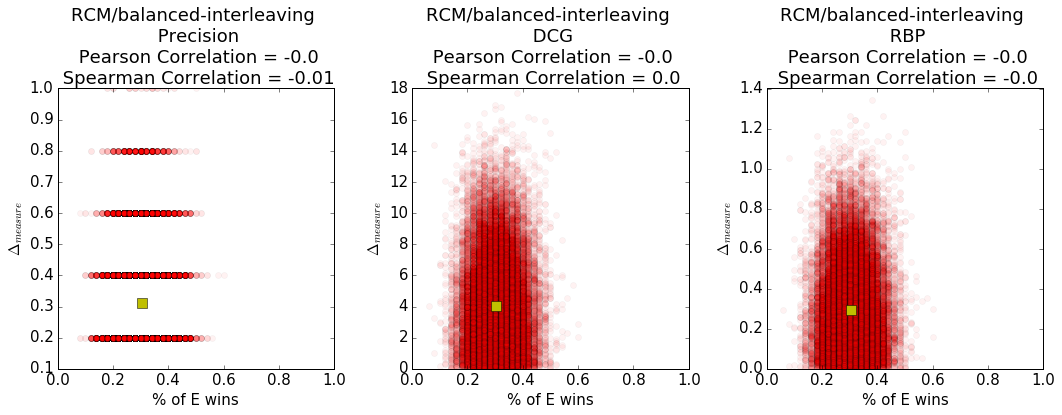

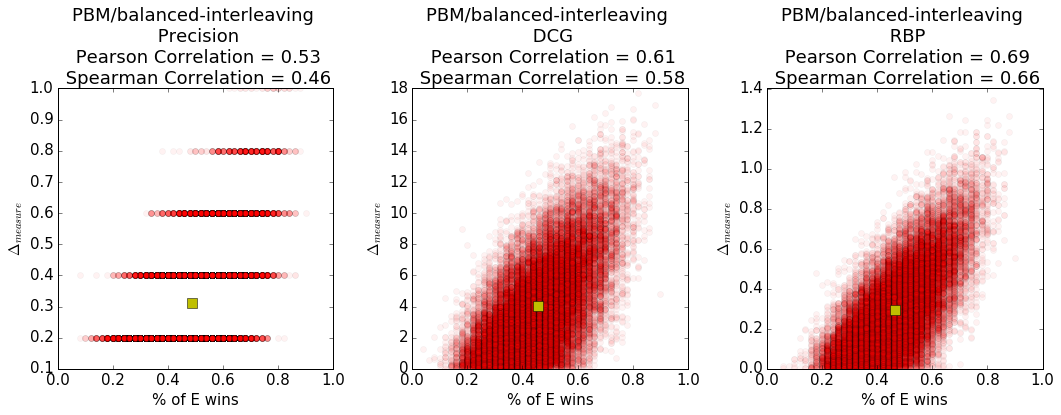

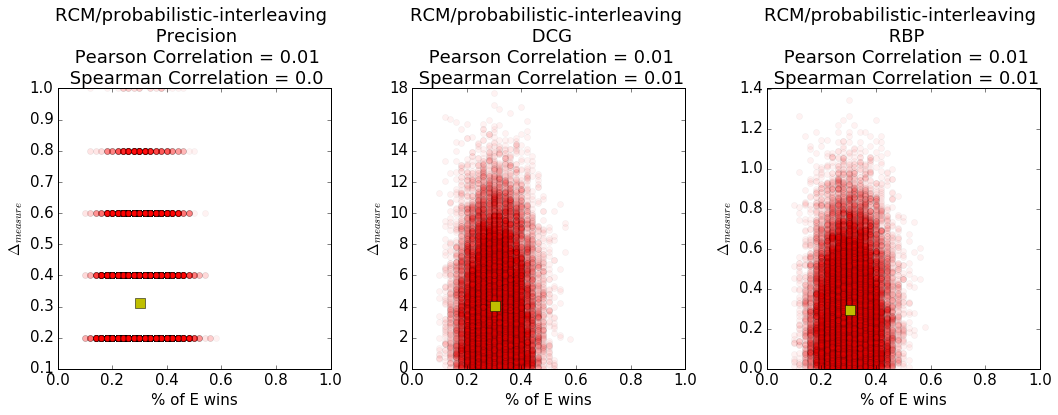

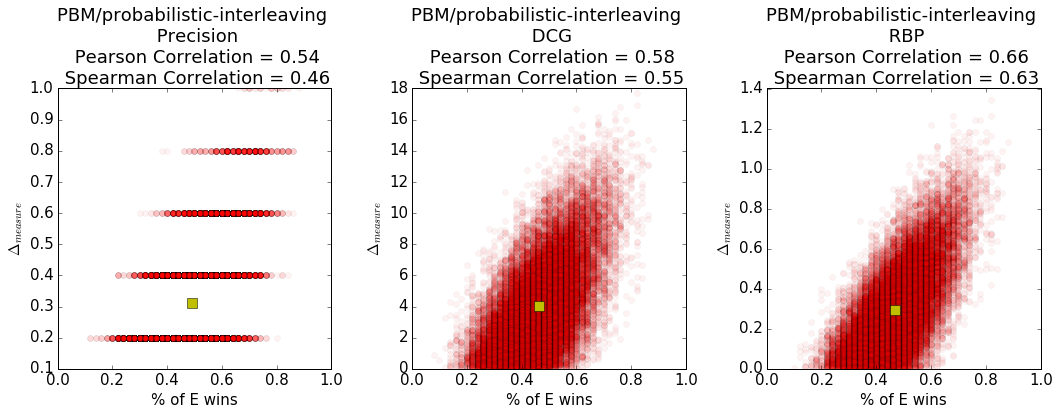

In [24]:
precision_l = [x[1] for x in measures if x[1] != None]
dcg_l = [x[2] for x in measures if x[2] != None]
rbp_l = [x[3] for x in measures if x[3] != None]

RC_balanced_precision_l = [x[0] for j, x in enumerate(individual_results) if measures[j][1] != None]
RC_balanced_dcg_l = [x[0] for j, x in enumerate(individual_results) if measures[j][2] != None]
RC_balanced_rbp_l = [x[0] for j, x in enumerate(individual_results) if measures[j][3] != None]

PBM_balanced_precision_l = [x[1] for j, x in enumerate(individual_results) if measures[j][1] != None]
PBM_balanced_dcg_l = [x[1] for j, x in enumerate(individual_results) if measures[j][2] != None]
PBM_balanced_rbp_l = [x[1] for j, x in enumerate(individual_results) if measures[j][3] != None]

RC_probabilistic_precision_l = [x[2] for j, x in enumerate(individual_results) if measures[j][1] != None]
RC_probabilistic_dcg_l = [x[2] for j, x in enumerate(individual_results) if measures[j][2] != None]
RC_probabilistic_rbp_l = [x[2] for j, x in enumerate(individual_results) if measures[j][3] != None]

PBM_probabilistic_precision_l = [x[3] for j, x in enumerate(individual_results) if measures[j][1] != None]
PBM_probabilistic_dcg_l = [x[3] for j, x in enumerate(individual_results) if measures[j][2] != None]
PBM_probabilistic_rbp_l = [x[3] for j, x in enumerate(individual_results) if measures[j][3] != None]

entries = [[RC_balanced_precision_l, precision_l, "RCM/balanced-interleaving", "Precision"], 
           [RC_balanced_dcg_l, dcg_l, "RCM/balanced-interleaving", "DCG"], 
           [RC_balanced_rbp_l, rbp_l, "RCM/balanced-interleaving", "RBP"],
          [PBM_balanced_precision_l, precision_l, "PBM/balanced-interleaving", "Precision"], 
           [PBM_balanced_dcg_l, dcg_l, "PBM/balanced-interleaving", "DCG"], 
           [PBM_balanced_rbp_l, rbp_l, "PBM/balanced-interleaving", "RBP"], 
          [RC_probabilistic_precision_l, precision_l, "RCM/probabilistic-interleaving", "Precision"], 
           [RC_probabilistic_dcg_l, dcg_l, "RCM/probabilistic-interleaving", "DCG"], 
           [RC_probabilistic_rbp_l, rbp_l, "RCM/probabilistic-interleaving", "RBP"],
          [PBM_probabilistic_precision_l, precision_l, "PBM/probabilistic-interleaving", "Precision"], 
           [PBM_probabilistic_dcg_l, dcg_l, "PBM/probabilistic-interleaving", "DCG"], 
           [PBM_probabilistic_rbp_l, rbp_l, "PBM/probabilistic-interleaving", "RBP"]]

matplotlib.rcParams.update({'font.size': 15})
for j in range(4):
    plt.subplots(1,3,figsize=(15,6))
    for i in range(3):
        ax = plt.subplot(131 + i)
        p = pearsonr(entries[i+3*j][0], entries[i+3*j][1])
        s = spearmanr(entries[i+3*j][0], entries[i+3*j][1])
        title = entries[i+3*j][2] + " \n " + entries[i+3*j][3] + "\n Pearson Correlation = " + str(round(p[0],2))
        title1 = "\n Spearman Correlation = " + str(round(s[0],2))
        ax.set_title(title + title1)
        ax.set_xlabel("% of E wins")
        ax.set_ylabel("$\Delta_{measure}$")
        ax.set_xlim([0,1])
        plt.plot(entries[i+3*j][0], entries[i+3*j][1], 'ro', alpha = 0.05)
        centroid = (sum(entries[i+3*j][0]) / len(entries[i+3*j][0]), sum(entries[i+3*j][1]) / len(entries[i+3*j][1]))
        plt.plot(centroid[0], centroid[1], 'ys', markersize = 10)

    plt.tight_layout()